https://x.com/dannchu/status/1880296123061137818

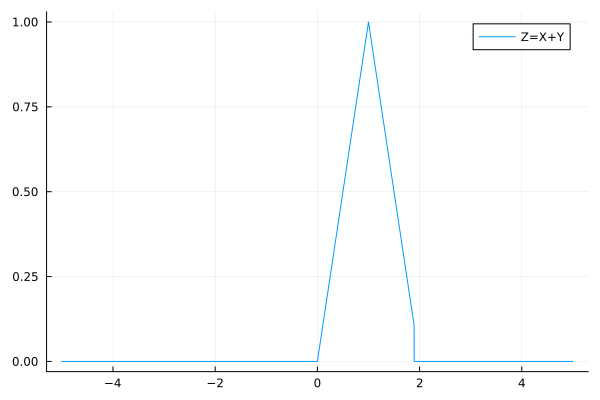

In [1]:
using QuadGK,Plots
default(fmt=:png)

f_X(x) = 0 ≤ x ≤ 1 ? 1 : 0
f_Y(y) = 0 ≤ y ≤ 1 ? 1 : 0

function f_Z(z)
    quadgk(t -> f_X(z-t)*f_Y(t) , -Inf, Inf)[1]
end

plot(f_Z,label="Z=X+Y")

## 不連続関数の`quadgk`はうまく行かない.

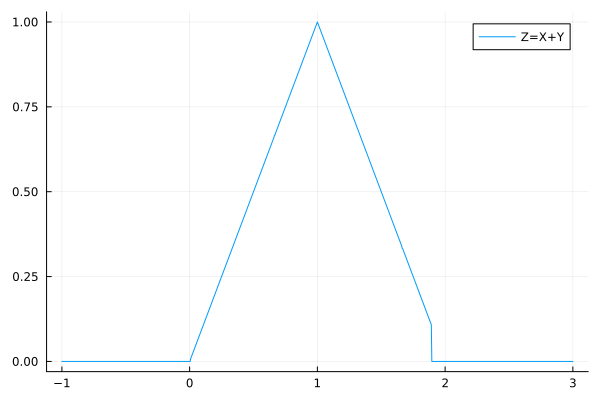

In [2]:
plot(range(-1, 3, 1001), f_Z; label="Z=X+Y")

In [3]:
@show f_Z(1.89) f_Z(1.9);

f_Z(1.89) = 0.11000165353464943
f_Z(1.9) = 0.0


## convolutionの実装

<img src="IMG_7804.jpeg" width=500>

In [4]:
using Distributions
using QuadGK
using StatsPlots
default(fmt=:png, legendfontsize=12)

# Assume that f is continuous on (a, b) and g is continuous on (c, d). 
function _convolution((f, a, b), (g, c, d))
    function h(z)
        (z ≤ a+c || b+d ≤ z) && return zero(float(z))
        if b+c ≤ a+d
            tmin = z ≤ a+d ? a : z-d
            tmax = z ≤ b+c ? z-c : b
            quadgk(t->f(t)*g(z-t), tmin, tmax)[1]
        else
            tmin = z ≤ b+c ? c : z-b
            tmax = z ≤ a+d ? z-a : d
            quadgk(t->f(z-t)*g(t), tmin, tmax)[1]
        end
    end
    return (h, a+c, b+d)
end

pdf_convolution(distx::ContinuousUnivariateDistribution, disty::ContinuousUnivariateDistribution) =
    _convolution((x->pdf(distx, x), extrema(distx)...), (y->pdf(disty, y), extrema(disty)...))

pdf_convolution(distx::ContinuousUnivariateDistribution, (g, c, d)) =
    _convolution((x->pdf(distx, x), extrema(distx)...), (g, c, d))

pdf_convolution((f, a, b), disty::ContinuousUnivariateDistribution) =
    _convolution((f, a, b), (y->pdf(disty, y), extrema(disty)...))

pdf_convolution (generic function with 3 methods)

In [5]:
d = Uniform()
f2 = pdf_convolution(d, d)
f3 = pdf_convolution(d, f2)
f4 = pdf_convolution(d, f3)
f5 = pdf_convolution(d, f4)
@time f5[1](1.0)

  2.982178 seconds (10.10 M allocations: 496.113 MiB, 2.58% gc time, 99.99% compilation time)


0.041666666666666664

  0.636363 seconds (1.96 M allocations: 96.821 MiB, 2.24% gc time, 99.74% compilation time: 80% of which was recompilation)


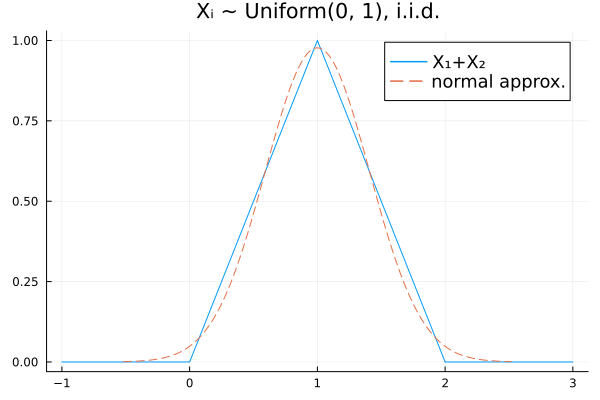

In [6]:
@time plot(f2[1], f2[2]-1, f2[3]+1; label="X₁+X₂")
plot!(Normal(2mean(Uniform()), √2 * std(Uniform())); label="normal approx.", ls=:dash)
title!("Xᵢ ~ Uniform(0, 1), i.i.d.")

  0.075536 seconds (127.07 k allocations: 6.022 MiB, 97.40% compilation time)


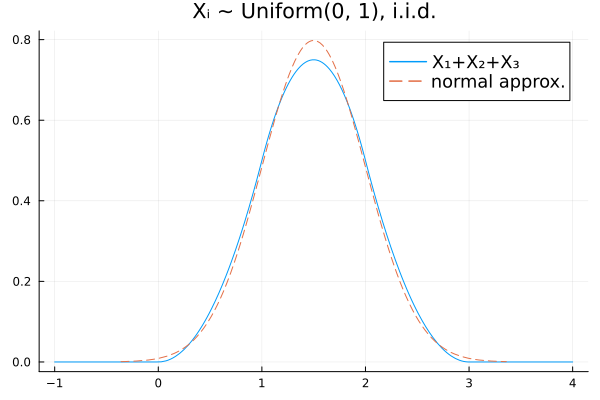

In [7]:
@time plot(f3[1], f3[2]-1, f3[3]+1; label="X₁+X₂+X₃")
plot!(Normal(3mean(Uniform()), √3 * std(Uniform())); label="normal approx.", ls=:dash)
title!("Xᵢ ~ Uniform(0, 1), i.i.d.")

  0.340044 seconds (538.22 k allocations: 33.545 MiB, 55.54% compilation time)


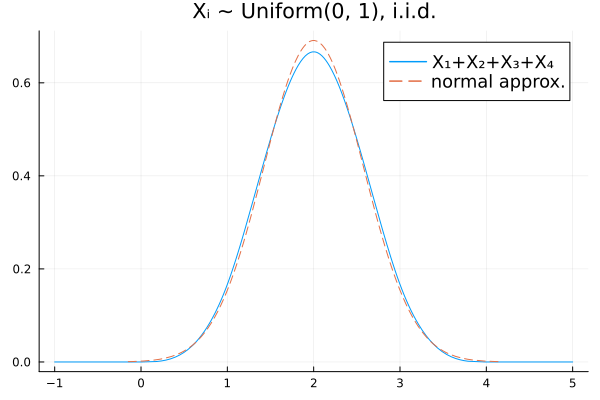

In [8]:
@time plot(f4[1], f4[2]-1, f4[3]+1; label="X₁+X₂+X₃+X₄")
plot!(Normal(4mean(Uniform()), √4 * std(Uniform())); label="normal approx.", ls=:dash)
title!("Xᵢ ~ Uniform(0, 1), i.i.d.")

 13.102726 seconds (26.76 M allocations: 1.964 GiB, 2.01% gc time, 1.50% compilation time)


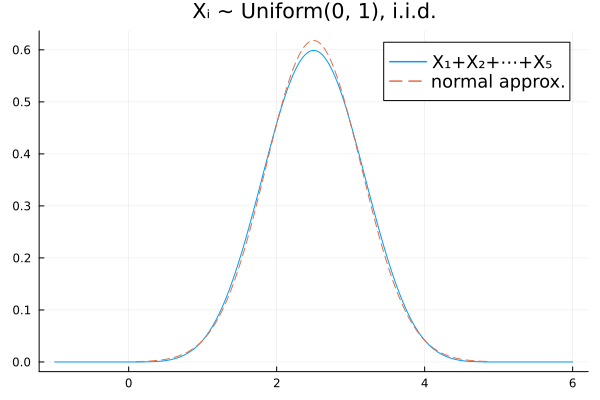

In [9]:
@time plot(f5[1], f5[2]-1, f5[3]+1; label="X₁+X₂+⋯+X₅")
plot!(Normal(5mean(Uniform()), √5 * std(Uniform())); label="normal approx.", ls=:dash)
title!("Xᵢ ~ Uniform(0, 1), i.i.d.")

本当は[`Distributions.convolve`](https://juliastats.org/Distributions.jl/latest/convolution/)を任意の単変量連続分布達について実装するべき.

distx = Normal{Float64}(μ=1.0, σ=3.0)
disty = Normal{Float64}(μ=2.0, σ=4.0)


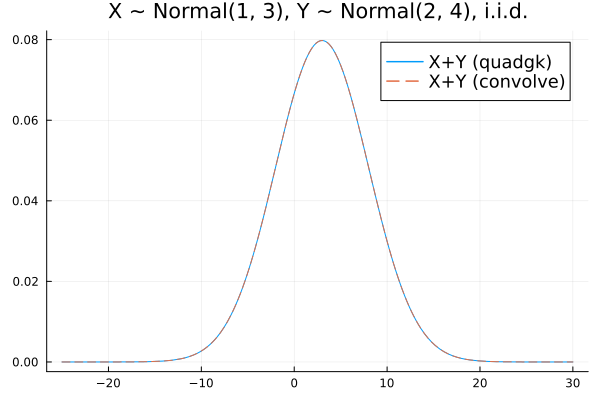

In [10]:
distx, disty = Normal(1, 3), Normal(2, 4)
@show distx disty
h = pdf_convolution(distx, disty)
distz = convolve(distx, disty)
plot(h[1], -25, 30; label="X+Y (quadgk)")
plot!(distz, -25, 30; label="X+Y (convolve)", ls=:dash)
title!("X ~ Normal(1, 3), Y ~ Normal(2, 4), i.i.d.")

distx = Gamma{Float64}(α=2.0, θ=1.0)
disty = Gamma{Float64}(α=3.0, θ=1.0)


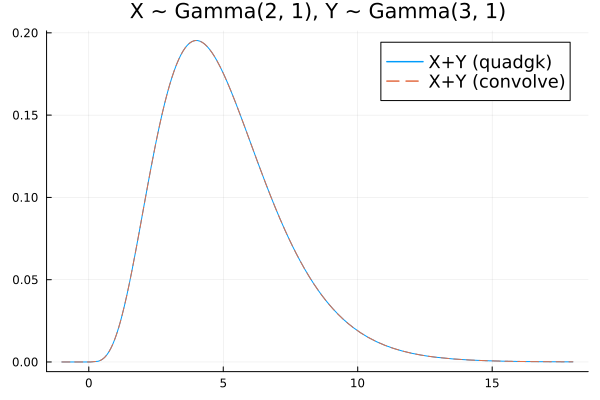

In [11]:
distx, disty = Gamma(2, 1), Gamma(3, 1)
@show distx disty
h = pdf_convolution(distx, disty)
distz = convolve(distx, disty)
plot(h[1], -1, 18; label="X+Y (quadgk)")
plot!(distz, -1, 18; label="X+Y (convolve)", ls=:dash)
title!("X ~ Gamma(2, 1), Y ~ Gamma(3, 1)")

In [12]:
distx, disty = Normal(0, 1), Gamma(3, 1)
@show distx disty
h = pdf_convolution(distx, disty)
distz = convolve(distx, disty)
plot(h[1], -4, 12; label="X+Y (quadgk)")
plot!(distz, -4, 18; label="X+Y (convolve)", ls=:dash)
title!("X ~ Normal(0, 1), Y ~ Gamma(3, 1), i.i.d.")

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Gamma{Float64}(α=3.0, θ=1.0)


LoadError: MethodError: no method matching convolve(::Normal{Float64}, ::Gamma{Float64})
The function `convolve` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  convolve([91m::Gamma[39m, ::Gamma)
[0m[90m   @[39m [35mDistributions[39m [90mD:\.julia\packages\Distributions\j0ZcJ\src\[39m[90m[4mconvolution.jl:74[24m[39m
[0m  convolve(::Normal, [91m::Normal[39m)
[0m[90m   @[39m [35mDistributions[39m [90mD:\.julia\packages\Distributions\j0ZcJ\src\[39m[90m[4mconvolution.jl:65[24m[39m
[0m  convolve([91m::Chisq[39m, [91m::Chisq[39m)
[0m[90m   @[39m [35mDistributions[39m [90mD:\.julia\packages\Distributions\j0ZcJ\src\[39m[90m[4mconvolution.jl:67[24m[39m
[0m  ...


distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Gamma{Float64}(α=3.0, θ=1.0)


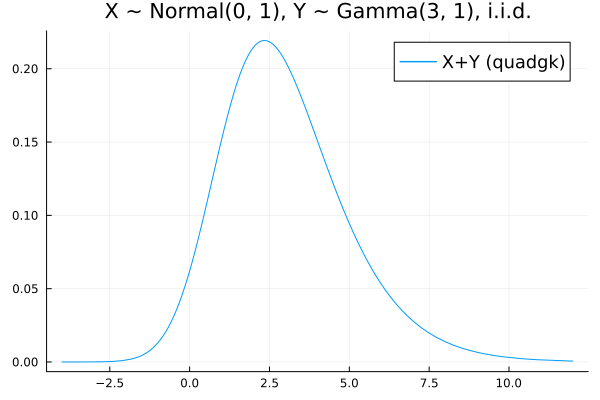

In [13]:
distx, disty = Normal(0, 1), Gamma(3, 1)
@show distx disty
h = pdf_convolution(distx, disty)
#distz = convolve(distx, disty)
plot(h[1], -4, 12; label="X+Y (quadgk)")
#plot!(distz, -4, 18; label="X+Y (convolve)", ls=:dash)
title!("X ~ Normal(0, 1), Y ~ Gamma(3, 1), i.i.d.")